In [2]:
import torch
import cv2
import mediapipe as mp
import numpy as np
import os
import random
import gc
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip, concatenate_videoclips
from IPython.display import Image, clear_output
from torch.cuda import memory_allocated, empty_cache
from torch.optim import Adam
from torch.utils.data import random_split
from torch.utils.data import Dataset, DataLoader
from glob import glob
from tqdm import tqdm
%matplotlib inline

### 모델 사용에 있어서 영상 처리하는 도구 선언
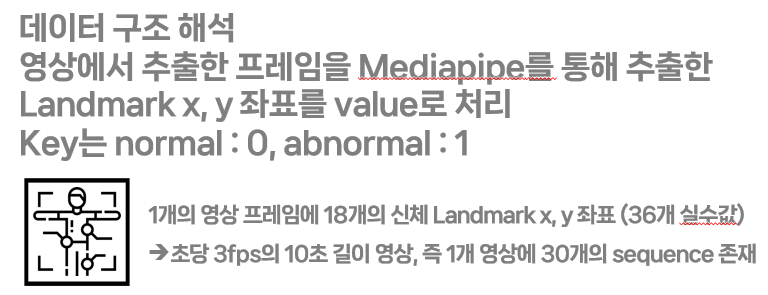


* 영상 입력 -> yolo를 이용해 객체 탐지 -> mediapipe를 통해 관절 좌표 추출 -> 모델 입력 -> 탐지

In [3]:
# torch_ver Yolov5
yolo_model = torch.hub.load('ultralytics/yolov5', 'yolov5s', device='cuda:0' if torch.cuda.is_available() else 'cpu')  # 예측 모델
yolo_model.classes = [0]  # 예측 클래스 (0 : 사람)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Using cache found in C:\Users\Playdata/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2024-4-18 Python-3.11.8 torch-2.2.1 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


In [4]:
start_dot = 11      # mp.solutions.pose 시작 포인트 (0: 얼굴부터 발목까지, 11: 어깨부터 발목까지)
n_CONFIDENCE = 0.3    # MediaPipe Min Detectin confidence check
y_CONFIDENCE = 0.3    # Yolv5 Min Detectin confidence check
mp_pose = mp.solutions.pose
attention_dot = [n for n in range(start_dot, 29)]
# 라인 그리기
"""몸 부분만"""
draw_line = [[11, 13], [13, 15], [15, 21], [15, 19], [15, 17], [17, 19], \
            [12, 14], [14, 16], [16, 22], [16, 20], [16, 18], [18, 20], \
            [23, 25], [25, 27], [24, 26], [26, 28], [11, 12], [11, 23], \
            [23, 24], [12, 24]]


# Yolov4 바운딩 box 안에서 media pipe 데이터 전처리 함수

def get_skeleton(video_path, attention_dot, draw_line):
    frame_length = 30 # LSTM 모델에 넣을 frame 수

    xy_list_list, xy_list_list_flip = [], []
    cv2.destroyAllWindows()
    pose = mp_pose.Pose(static_image_mode = True, model_complexity = 1, \
                        enable_segmentation = False, min_detection_confidence = n_CONFIDENCE)
    cap = cv2.VideoCapture(video_path)

    if cap.isOpened():

        while True:
            ret, img = cap.read()

            if ret == True:

                """ Yolo 바운딩 박스 및 좌표 추출"""
                img = cv2.resize(img, (640, 640))
                res = yolo_model(img)
                res_refine = res.pandas().xyxy[0].values
                nms_human = len(res_refine)
                if nms_human > 0:
                    for bbox in res_refine:
                        """바운딩 박스 상하좌우 크기 조절"""
                        xx1, yy1, xx2, yy2 = int(bbox[0])-10, int(bbox[1]), int(bbox[2])+10, int(bbox[3])
                        if xx1 < 0:
                            xx1 = 0
                        elif xx2 > 639:
                            xx2 = 639
                        if yy1 < 0:
                            yy1 = 0
                        elif yy2 > 639:
                            yy2 = 639

                        start_point = (xx1, yy1)
                        end_point = (xx2, yy2)
                        if bbox[4] > y_CONFIDENCE: # bbox[4] : confidence 데이터
                            c_img = img[yy1:yy2, xx1:xx2] # 바운딩 박스 좌표
                            results = pose.process(cv2.cvtColor(c_img, cv2.COLOR_BGR2RGB))
                            if not results.pose_landmarks: continue
                            idx = 0
                            draw_line_dic = {}
                            xy_list, xy_list_flip = [], []
                            for x_and_y in results.pose_landmarks.landmark:
                                if idx in attention_dot:
                                    xy_list.append(x_and_y.x)
                                    xy_list.append(x_and_y.y)
                                    xy_list_flip.append(1 - x_and_y.x)
                                    xy_list_flip.append(x_and_y.y)

                                    x, y = int(x_and_y.x*(xx2-xx1)), int(x_and_y.y*(yy2-yy1))
                                    draw_line_dic[idx] = [x, y]
                                idx += 1

                            if len(xy_list) != len(attention_dot) * 2:
                                print('Error : attention_dot 데이터 오류')

                            xy_list_list.append(xy_list)
                            xy_list_list_flip.append(xy_list_flip)

            elif ret == False: break

        # 부족한 프레임 수 맞추기
        if len(xy_list_list_flip) < 15:
            return False, False
        elif len(xy_list_list_flip) < frame_length:
            f_ln = frame_length - len(xy_list_list_flip)
            for _ in range(f_ln):
                xy_list_list.append(xy_list_list[-1])
                xy_list_list_flip.append(xy_list_list_flip[-1])

    cap.release()
    cv2.destroyAllWindows()

    return xy_list_list, xy_list_list_flip

In [5]:
class MyDataset(Dataset):
    def __init__(self, seq_list):
        self.X = []
        self.y = []
        for dic in seq_list :
            self.y.append(dic['key'])
            self.X.append(dic['value'])

    def __getitem__(self, index):
        data = self.X[index]
        label = self.y[index]
        return torch.Tensor(np.array(data)), torch.tensor(np.array(int(label)))

    def __len__(self):
        return len(self.X)
    
# LSTM
class skeleton_LSTM(nn.Module):
    def __init__(self):
        super(skeleton_LSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_size=len(attention_dot) * 2, hidden_size=128, num_layers=NUM_LAYERS, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=128, hidden_size=256, num_layers=NUM_LAYERS, batch_first=True)
        self.lstm3 = nn.LSTM(input_size=256, hidden_size=512, num_layers=NUM_LAYERS, batch_first=True)
        self.dropout1 = nn.Dropout(0.1)
        self.lstm4 = nn.LSTM(input_size=512, hidden_size=256, num_layers=NUM_LAYERS, batch_first=True)
        self.lstm5 = nn.LSTM(input_size=256, hidden_size=128, num_layers=NUM_LAYERS, batch_first=True)
        self.lstm6 = nn.LSTM(input_size=128, hidden_size=64, num_layers=NUM_LAYERS, batch_first=True)
        self.dropout2 = nn.Dropout(0.1)
        self.lstm7 = nn.LSTM(input_size=64, hidden_size=32, num_layers=NUM_LAYERS, batch_first=True)
        self.fc = nn.Linear(32,2)

    def forward(self, x) :
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x, _ = self.lstm3(x)
        x = self.dropout1(x)
        x, _ = self.lstm4(x)
        x, _ = self.lstm5(x)
        x, _ = self.lstm6(x)
        x = self.dropout2(x)
        x, _ = self.lstm7(x)
        x = self.fc(x[:,-1,:]) # x[배치 크기, 시퀀스 길이, 은닉 상태 크기], [:, -1, :] -> 마지막 시간 단계만 선택

        return x
    

def frame_save(test_video_path):
    cv2.destroyAllWindows()
    global img_list
    cap = cv2.VideoCapture(test_video_path)
    if cap.isOpened():

        while True:
            ret, img = cap.read()
            if ret:
                img = cv2.resize(img, (640, 640))
                img_list.append(img)
                # cv2_imshow(img)
                # cv2.waitKey(1)
            else:
                break

    cap.release()
    cv2.destroyAllWindows()
    return print('저장된 frame의 개수: {}'.format(len(img_list)))

# 기존 학습한 모델 불러오기

In [8]:
NUM_LAYERS = 1
model = skeleton_LSTM()
model.load_state_dict(torch.load('../model/mj_s_500_1_40.pt',map_location='cpu')) # 자신의 환경에 맞게 cpu or cuda 선택


<All keys matched successfully>

In [15]:
"""Yolov5 + Mediapipe Version"""
# 영상 resize 및 추출
test_video_name = '07_normal_30' # 영상이름 입력
test_video_path = f'../data/{test_video_name}.mp4' # 영상 경로
img_list = []
frame_save(test_video_path)


저장된 frame의 개수: 30


In [16]:
def img_func(img,model):
    global y_CONFIDENCE, xy_list_list, status,out_img_list
    res = yolo_model(img)
    res_refine = res.pandas().xyxy[0].values

    nms_human = len(res_refine)
    if nms_human > 0:
        for bbox in res_refine:
            xx1, yy1, xx2, yy2 = int(bbox[0])-10, int(bbox[1]), int(bbox[2])+10, int(bbox[3])
            if xx1 < 0:
                xx1 = 0
            elif xx2 > 639:
                xx2 = 639
            if yy1 < 0:
                yy1 = 0
            elif yy2 > 639:
                yy2 = 639

            start_point = (xx1, yy1)
            end_point = (xx2, yy2)
            if bbox[4] > y_CONFIDENCE:
                img = cv2.rectangle(img, start_point, end_point, (0, 0, 255), 2)

                c_img = img[yy1:yy2, xx1:xx2]
                results = pose.process(cv2.cvtColor(c_img, cv2.COLOR_BGR2RGB)) # Yolo 바운딩 box 안에서 landmark dot 추출
                if not results.pose_landmarks: continue
                xy_list = []
                idx = 0
                draw_line_dic = {}
                for x_and_y in results.pose_landmarks.landmark:
                    if idx in attention_dot:
                        xy_list.append(x_and_y.x)
                        xy_list.append(x_and_y.y)
                        x, y = int(x_and_y.x*(xx2-xx1)), int(x_and_y.y*(yy2-yy1))
                        draw_line_dic[idx] = [x, y]
                    idx += 1

                xy_list_list.append(xy_list)
                for line in draw_line:
                    x1, y1 = draw_line_dic[line[0]][0], draw_line_dic[line[0]][1]
                    x2, y2 = draw_line_dic[line[1]][0], draw_line_dic[line[1]][1]
                    c_img = cv2.line(c_img, (x1, y1), (x2, y2), (0, 255, 0), 3)

                if len(xy_list_list) == length:
                    dataset = []
                    dataset.append({'key' : 0, 'value' : xy_list_list})
                    dataset = MyDataset(dataset)
                    dataset = DataLoader(dataset)
                    xy_list_list = []

                    for data, label in dataset:
                        data = data.to(device)
                        with torch.no_grad():
                            result = model(data)
                            _, out = torch.max(result, 1)
                            if out.item() == 0: status = 'Normal'
                            else: status = 'Theft'

    cv2.putText(img, status, (0, 50), cv2.FONT_HERSHEY_COMPLEX, 1.5, (0, 0, 255), 2)
    out_img_list.append(img)

In [17]:
model.eval()
length = 30 # frame 상태를 표시할 길이
out_img_list = []
dataset = []
status = 'None'
pose = mp_pose.Pose(static_image_mode=True, model_complexity=1, enable_segmentation=False, min_detection_confidence=n_CONFIDENCE)
print('시퀀스 데이터 분석 중...')

xy_list_list = []
for img in tqdm(img_list):
    img_func(img,model)
    
# 테스트 원본 영상 내보내기
filename = 'test.mp4'
fourcc = cv2.VideoWriter_fourcc(*'DIVX')
fps = 3
frameSize = (640, 640)
out = cv2.VideoWriter(filename, fourcc, fps, frameSize)
for out_img in out_img_list:
    out.write(out_img)
out.release()
clip_video = VideoFileClip(filename)
clip_video.ipython_display(width = 480)

시퀀스 데이터 분석 중...


100%|██████████| 30/30 [00:08<00:00,  3.75it/s]


Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4
